### Introduction

**What are Legendgrams?** ðŸ“Š
A legendgram is a data visualization tool that combines a color legend with a histogram. Instead of a simple color bar showing a range of values, a legendgram adds a histogram to the side of the image. This visualization instantly shows you how your data is distributed across the different colors on your map.

Imagine you have a spatial map showing the density of a certain cell type, with a color legend ranging from white (low density) to red (high density). A traditional legend tells you what colors represent what values, but it doesn't tell you how many areas on your map fall into each color range. A legendgram, however, would have bars on its side, immediately showing you if most of your cells are in the low-density white range, the high-density red range, or somewhere in between.

In the last [tutorial](https://hautaniemilab.github.io/histolytics/user_guide/spatial/partitioning/) we computed grid aggregates of histological features within defined tissue regions. In this tutorial, we will add a legendgram to the visualization to learn the distribution of our custom metric at different parts of the tissue. More specifically, we will compare the immune-connective cell ratio distributions between the lesion-stroma interface and the stroma.

In [ ]:
import pandas as pd
from histolytics.data import cervix_nuclei, cervix_tissue
from histolytics.spatial_ops.ops import get_interfaces
from histolytics.spatial_ops.h3 import h3_grid
from histolytics.spatial_agg import grid_aggregate
from histolytics.utils.plot import legendgram
from scipy.stats import rankdata


# This function will compute the ratio of immune to connective cells within each grid cell
# In general, any function that takes a GeoDataFrame and returns a scalar
# can be used here. Typically, this will be a function that calculates
# a count, sum, mean, or other statistic of interest out of the nuclei.
def immune_connective_ratio(nuclei):
    """Calculate the immune to connective cell ratio in a grid cell."""
    if "inflammatory" in nuclei.value_counts("class_name"):
        immune_cnt = nuclei.value_counts("class_name", normalize=True)["inflammatory"]
    else:
        immune_cnt = 0

    if "connective" in nuclei.value_counts("class_name"):
        connective_cnt = nuclei.value_counts("class_name", normalize=True)["connective"]
    else:
        connective_cnt = 0

    if connective_cnt > 0:
        return float(immune_cnt / connective_cnt)
    else:
        return 0


# quantile normalization function
def qnorm(values: pd.Series):
    """Quantile normalize a pandas Series."""
    ranks = rankdata(values, method="average")
    quantile_normalized = (ranks - 1) / (len(ranks) - 1)
    return quantile_normalized


# Load data
tis = cervix_tissue()
nuc = cervix_nuclei()

# get the stroma and lesion (cin) tissue segmentations
stroma = tis[tis["class_name"] == "stroma"]
cin_tissue = tis[tis["class_name"] == "cin"]

# get the lesion-stroma-interface
interface = get_interfaces(cin_tissue, stroma, buffer_dist=300)
interface = interface.assign(class_name="lesion-stroma-interface")

# fit a hexagonal grid to the interface
h3_res10_inter = h3_grid(interface, resolution=10)
# fit a hexagonal grid to the stroma
h3_res10_stroma = h3_grid(stroma, resolution=10)

# immune-connective-ratio at the interface
h3_res10_inter = grid_aggregate(
    objs=nuc,
    grid=h3_res10_inter,
    metric_func=immune_connective_ratio,
    new_col_names=["immune_connective_ratio"],
    predicate="intersects",
    num_processes=2,
)

# immune-connective-ratio at the stroma
h3_res10_stroma = grid_aggregate(
    objs=nuc,
    grid=h3_res10_stroma,
    metric_func=immune_connective_ratio,
    new_col_names=["immune_connective_ratio"],
    predicate="intersects",
    num_processes=2,
)

h3_res10_inter = h3_res10_inter.assign(
    immune_connective_ratio_qnorm=qnorm(h3_res10_inter["immune_connective_ratio"])
)
h3_res10_stroma = h3_res10_stroma.assign(
    immune_connective_ratio_qnorm=qnorm(h3_res10_stroma["immune_connective_ratio"])
)

### Immune-Connective Cell Ratio Distribution at the Lesion-stroma Interface

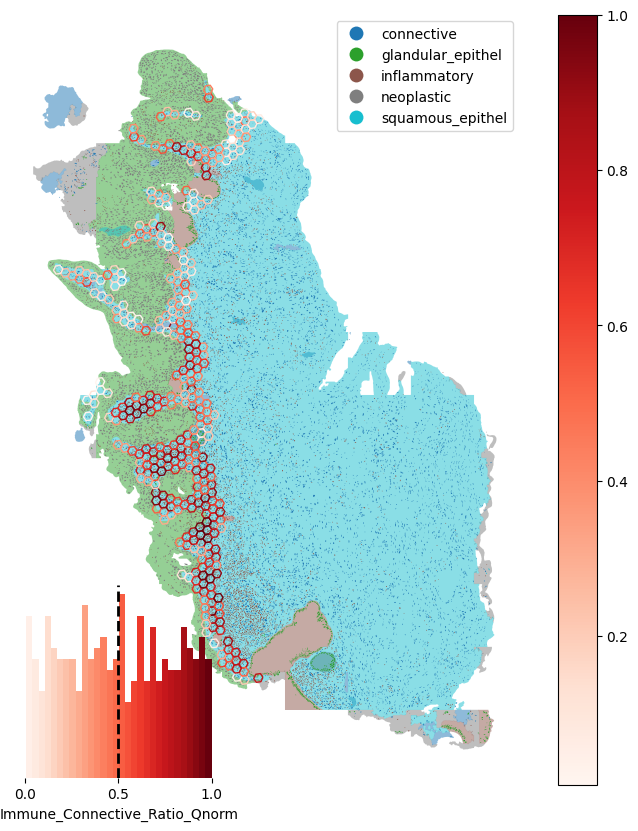

In [2]:
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=True)
h3_res10_inter.plot(
    ax=ax,
    column="immune_connective_ratio_qnorm",
    cmap="Reds",
    legend=True,
    aspect=1,
    facecolor="none",
)
ax.set_axis_off()

# Add a legendgram to visualize the distribution of immune cell density
ax = legendgram(
    gdf=h3_res10_inter,
    column="immune_connective_ratio_qnorm",
    n_bins=30,
    cmap="Reds",
    ax=ax,
)

We see relatively uniform distribution of immune-connective cell ratios across the lesion-stroma-interface

### Immune-Connective Cell Ratio Distribution at the Stroma

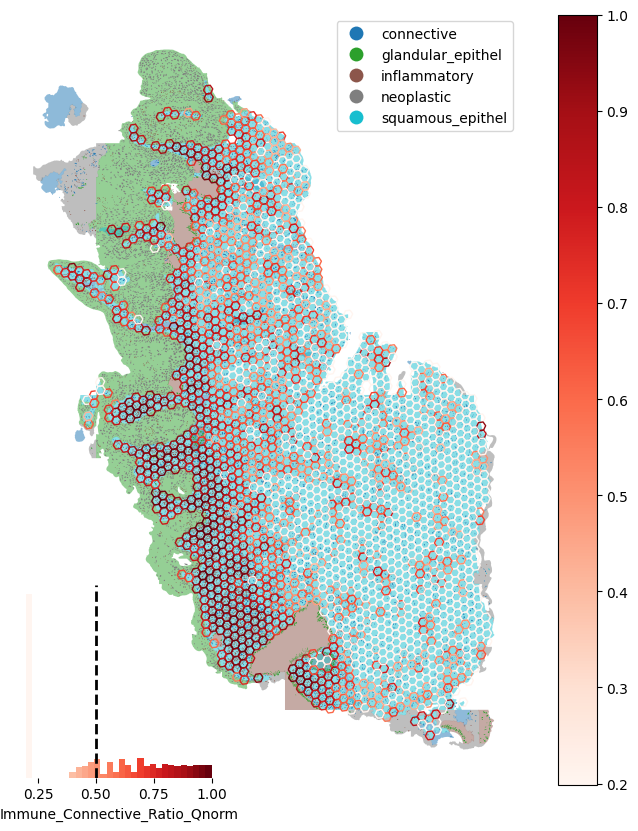

In [3]:
# We will quantile normalize the result to smooth out extremes
h3_res10_stroma = h3_res10_stroma.assign(
    immune_connective_ratio_qnorm=qnorm(h3_res10_stroma["immune_connective_ratio"])
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=True)
h3_res10_stroma.plot(
    ax=ax,
    column="immune_connective_ratio_qnorm",
    cmap="Reds",
    legend=True,
    aspect=1,
    facecolor="none",
)
ax.set_axis_off()

# Add a legendgram to visualize the distribution of immune cell density
ax = legendgram(
    gdf=h3_res10_stroma,
    column="immune_connective_ratio_qnorm",
    n_bins=30,
    cmap="Reds",
    ax=ax,
)

The immune-connective cell ratio distribution at the stroma shows a more pronounced variation, where the distal stromal regions exhibit very low ratios indicating higher proportions of connective cells. The grid cells closer to the lesion show a more uniform distribution of immune-connective cell ratios.

### Extra

If you don't want to add the legendgram to the Axes object and you want it as a separate figure, you can do so by just calling the `legendgram` function without specifying an `ax` parameter. Different matplotlib colormaps can be used too (e.g. viridis, plasma, inferno, turbo etc...).

<Axes: xlabel='Immune_Connective_Ratio_Qnorm'>

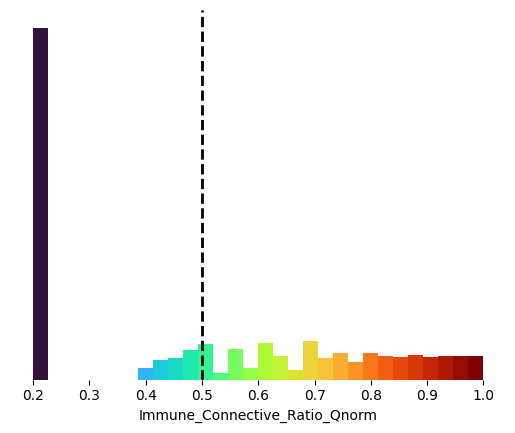

In [6]:
import matplotlib.pyplot as plt

ax = legendgram(
    gdf=h3_res10_stroma,
    column="immune_connective_ratio_qnorm",
    n_bins=30,
    cmap="turbo",
)
ax